# Benchmark of the AutoML tool

In this notebook, we will show the benchmark of the different metrics

### Importing the tool and libraries

In [1]:
from automl_iasd.IASDAutoML import IASDAutoML
from automl_iasd.feature_engineering.selection import nrpa_feature_selector, snrpa_feature_selector
from pyspark.sql import SparkSession
import seaborn as sns 
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from automl_iasd.feature_engineering.util import get_max_count_distinct
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import MultilayerPerceptronClassifier
import pandas as pd
import numpy as np

In [3]:
spark = SparkSession \
.builder \
.appName("IASDAutoML") \
.config("spark.driver.memory", "12g") \
.getOrCreate()

### Loading the datasets 

We will perform the benchmark on 8 datasets, we will start by import them. They are all present in the `datasets` folder. 
Those dataframes presents some specificities that will help us to see how good the tool can handle them.

In [4]:
airlines_dataframe = spark.read.parquet(f"../datasets/airlines.parquet/",inferSchema=True, header=True)
adult_dataframe = spark.read.parquet(f"../datasets/adult.parquet/",inferSchema=True, header=True)
seismic_bump_dataframe = spark.read.parquet(f"../datasets/seismic-bumps.parquet/",inferSchema=True, header=True)
spect_dataframe = spark.read.parquet(f"../datasets/spect.parquet/",inferSchema=True, header=True)

### Benchmarking the feature selection process

In the feature selection process, we use the monte-carlo algorithm : NRPA and SNRPA<br>
They both have different hyperparameters that we will highlight<br> 
We will start by applying all the transformations to have the right dataframe

### Evaluating different search levels 
In this part we will evaluate the time taken and the average score (over 3 run for 4 differents search level [0,1,2,3]). We will set alpha as 1.0 and the number of iteratinos as 100. We will evaluate first NRPA and SNRPA after.

In [5]:
def average(lst):
    return sum(lst) / len(lst)

In [24]:
### airlines, logistic regression, n=[0,1,2,3], iterations=50
airlines_level_score_time = []
list_of_params = []
label_column_name = "Delay"
to_avg_iterations = 3
pipeline = IASDAutoML(budget=2, dataframe=airlines_dataframe, label_column_name=label_column_name)
generated_train_df, generated_val_df, columns_to_featurized, selection_initial_uniform_policy, categorical_columns_to_encode = pipeline.generate_dataframe_for_selection()

for algorithm in pipeline.classification_algorithms:
    algorithm_name = str(algorithm).split("_")[0]
    algorithm.setLabelCol(label_column_name)
    print(f"AutoFE : Feature selection - Selecting the best subset of features for {algorithm_name}... ")
    
    if algorithm_name == "DecisionTreeClassifier" or algorithm_name == "RandomForestClassifier":
        algorithm.setLabelCol("indexedLabel")
        print("ok")
        maximum_number_of_categories = get_max_count_distinct(generated_val_df, categorical_columns_to_encode)
        algorithm.setMaxBins(maximum_number_of_categories)
        
    for level in range(3):
        score = []
        time = []
        params = {}
        for n in range(to_avg_iterations):
            start = timer()
            bestScore, feature_selection = nrpa_feature_selector(0, 50, generated_train_df, generated_val_df, len(columns_to_featurized), algorithm, selection_initial_uniform_policy)
            feature_selection_indices = [i for i in range(len(feature_selection)) if feature_selection[i]=="Keep"]
            score.append(bestScore)
            end = timer()
            time.append(end-start)
            print(end - start) # Time in seconds 
        airlines_level_score_time.append([f"{algorithm_name}", level, average(score), average(time)])
        params.update({level: score})
    list_of_params.append([algorithm_name, params])
        
### airlines, RandomForest, n=0

### airlines, RandomForest, n=1

### airlines, RandomForest, n=2

### airlines, RandomForest, n=3

### airlines, DecisionTree, n=0

### airlines, DecisionTree, n=1

### airlines, DecisionTree, n=2

### airlines, DecisionTree, n=3

### airlines, MultiLayerPerceptron, n=0

### airlines, MultiLayerPerceptron, n=1

### airlines, MultiLayerPerceptron, n=2

### airlines, MultiLayerPerceptron, n=3

### airlines, NaiveBayes, n=0

### airlines, NaiveBayes, n=1

### airlines, NaiveBayes, n=2
b
### airlines, NaiveBayes, n=3


-------------------------------------------------------------------------------
---------------Starting the generation of the generated dataframe--------------
-------------------------------------------------------------------------------
The initial dataframe is the one below :


INFO:root:AutoFE - Splitting dataset ... 
INFO:root:AutoFE : Data preprocessing - Performing eventual missing values imputation ... 


+-------+------+-----------+---------+---------+------+------+-----+
|Airline|Flight|AirportFrom|AirportTo|DayOfWeek|  Time|Length|Delay|
+-------+------+-----------+---------+---------+------+------+-----+
|     MQ|2794.0|        GPT|      DFW|      2.0|1020.0| 110.0|  0.0|
|     MQ|3023.0|        LAX|      SAN|      2.0|1020.0|  45.0|  0.0|
|     MQ|3082.0|        SAN|      LAX|      2.0|1020.0|  45.0|  0.0|
|     MQ|3364.0|        TLH|      DFW|      2.0|1020.0| 150.0|  0.0|
|     MQ|3375.0|        DFW|      FSM|      2.0|1020.0|  60.0|  0.0|
|     MQ|3995.0|        DAY|      ORD|      2.0|1020.0|  80.0|  0.0|
|     MQ|4136.0|        JFK|      IND|      2.0|1020.0| 145.0|  0.0|
|     MQ|4329.0|        JFK|      CVG|      2.0|1020.0| 145.0|  0.0|
|     MQ|4589.0|        MSP|      LGA|      2.0|1020.0| 165.0|  1.0|
|     MQ|4661.0|        LGA|      ATL|      2.0|1020.0| 160.0|  0.0|
|     OH|6350.0|        DSM|      MSP|      2.0|1020.0|  66.0|  1.0|
|     OH|6544.0|        JFK|      

INFO:root:AutoFE : Data preprocessing - Encoding categorical features ...       
INFO:root:AutoFE : Feature generation - Applying unary operators ... 
21/10/28 12:11:39 WARN QuantileDiscretizer: Some quantiles were identical. Bucketing to 8 buckets as a result.
INFO:root:AutoFE : Feature generation - Applying binary and group by then operators ... 
INFO:root:AutoFE : Feature generation - Creating feature column ... 
INFO:root:AutoFE : Data Preprocessing - Applying normalizer and standardizer ... ]


AutoFE : Feature selection - Selecting the best subset of features for MultilayerPerceptronClassifier... 


0.5031392052664682
[0, 1, 4, 5, 6, 7, 14, 18, 19, 22]


110.49358211199979


0.5251163774698129
[0, 4, 6, 7, 8, 10, 11, 14, 15, 16, 17, 22, 23]


102.91035954500012


0.6079289874332492
[4, 10, 13, 16, 18, 22, 23]


84.11847223799987


0.5795419081980614
[1, 2, 3, 4, 5, 6, 7, 12, 13, 14, 16, 20, 22]


96.98093699699984


0.5075169353955586
[5, 6, 7, 11, 12, 13, 15, 16, 17, 19, 23]


92.83816427900001


0.5496283038141911
[0, 2, 3, 4, 5, 7, 9, 10, 12, 13, 14, 15, 16, 17, 22, 23]


96.47692815799974


0.5177007392851973
[0, 3, 4, 5, 8, 9, 11, 12, 14, 16, 17, 19, 23]


94.76296386700005


0.47289422826072985
[0, 3, 6, 8, 12, 15, 17, 19, 21, 23]


97.54005082499998


0.4273379758083435
[2, 5, 6, 9, 11, 13, 14, 16, 19, 20, 22]


94.544114541
AutoFE : Feature selection - Selecting the best subset of features for DecisionTreeClassifier... 
ok


0.5
[0, 1, 8, 10, 12, 15, 20, 21, 23]


129.03708392499993


0.4092679908253846
[3, 4, 5, 8, 10, 11, 12, 14, 15, 20, 21, 22]


119.40461356900005


0.4092679908253846
[1, 3, 4, 6, 9, 11, 14, 15, 20, 23]


249.2880355970001


0.4092679908253846
[2, 5, 7, 12, 16, 18, 19, 20, 23]


427.8726203340002


0.4092679908253846
[2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 15, 17, 18]


419.4448558989998


0.40158545027089704
[4, 5, 9, 12, 14, 16, 17, 18, 19, 20, 21, 22, 23]


270.36074650200044


0.40158545027089704
[1, 3, 7, 9, 12, 16, 18, 21]


117.09572062000007


0.4092679908253846
[0, 1, 5, 7, 10, 11, 12, 13, 14, 18, 20, 21, 22]


130.2279690109999


0.4092679908253846
[2, 3, 4, 6, 8, 9, 10, 12, 13, 14, 16, 17, 19, 20, 21, 23]


130.50966219300062
AutoFE : Feature selection - Selecting the best subset of features for LogisticRegression... 


0.6606799259473908
[0, 1, 2, 4, 7, 8, 9, 10, 12, 17, 18, 19, 21, 23]


211.19870296099998


0.550490224415267
[0, 3, 5, 6, 9, 13, 18, 19, 22]


102.40378129200053


0.6284444817618138
[0, 2, 5, 8, 9, 11, 15, 17, 18, 20, 22, 23]


97.98072516699995


0.6524817316619218
[0, 1, 2, 5, 7, 10, 11, 15, 18]


127.30640050700003


0.644579156999268
[3, 4, 7, 9, 12, 14, 15, 16, 20, 21, 23]


98.25608625399946


0.6273574466098519
[0, 1, 4, 6, 9, 12, 13, 14, 16, 18, 20]


133.11871171000075


0.621543561081358
[0, 1, 4, 6, 18, 19, 20, 22, 23]


125.42455317400072


0.6266451656759703
[0, 1, 4, 7, 8, 9, 12, 17, 19]


105.73699687499993


0.6693474448428437
[1, 2, 3, 4, 6, 7, 8, 9, 12, 15, 18, 20, 23]


127.43482210599996
AutoFE : Feature selection - Selecting the best subset of features for RandomForestClassifier... 
ok


0.643929915461527
[2, 3, 5, 6, 7, 10, 11, 12, 13, 18, 19, 23]


135.5528650489996


0.6173655293989482
[1, 4, 5, 6, 8, 10, 15, 20, 21]


129.08746161999989


0.6080929997409926
[0, 1, 3, 4, 6, 7, 8, 9, 12, 17, 21, 22, 23]


133.20721335500002


0.5975336165930336
[0, 3, 4, 5, 7, 10, 12, 17, 22]


142.2178511809998


0.6207039747838464
[0, 1, 3, 4, 7, 8, 9, 14, 16, 19, 20, 23]


259.88003542799925


0.6470227854951308
[0, 1, 2, 4, 6, 15, 16, 17, 18, 20, 21, 22, 23]


146.0534633010002


0.6254018541106359
[3, 5, 6, 7, 8, 10, 11, 12, 13, 16]


204.97160153200002


0.6081202200805336
[0, 1, 4, 5, 6, 7, 9, 10, 11, 12, 19, 20]


131.4036805630003


0.6561508196401904
[2, 7, 10, 11, 15, 16, 17, 19, 22, 23]


156.85335123200093
AutoFE : Feature selection - Selecting the best subset of features for NaiveBayes... 


0.4747514873720999
[0, 1, 2, 5, 7, 8, 9, 19, 20]


86.48133495900038


0.5247756065258882
[1, 2, 4, 5, 6, 7, 9, 13, 14, 15, 19, 20, 22]


110.41753349900137


0.4744435520913578
[0, 2, 7, 8, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22]


87.95072035200064


0.5320275527509949
[0, 1, 3, 4, 6, 8, 10, 14, 16, 17, 19, 22]


98.9988906790004


0.5067511662459914
[0, 1, 3, 4, 5, 8, 9, 14, 15, 16, 17, 18, 20, 22, 23]


105.39555473499968


0.4961018087679949
[2, 9, 10, 15, 18, 21, 22, 23]


75.2274405950011


0.4895342613270387
[0, 2, 4, 5, 6, 9, 10, 11, 13, 14, 15, 17, 18, 19, 23]


KeyboardInterrupt: 

In [17]:
df = pd.DataFrame(list_of_params[0][1])

In [14]:
baseline_score = 0.6

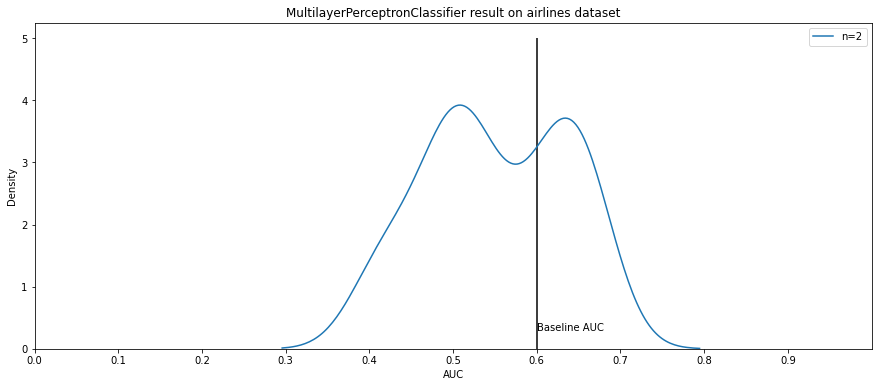

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.set_xlim(0, 1)
ax.set_title(f"{list_of_params[0][0]} result on airlines dataset")

sns.kdeplot(data=df, x=2, ax=ax, label=f'n=0')
sns.kdeplot(data=df, x=2, ax=ax, label=f'n=1')
sns.kdeplot(data=df, x=2, ax=ax, label=f'n=2')
sns.kdeplot(data=df, x=2, ax=ax, label=f'n=3')

ax.set_xticks([x/10 for x in range(10)])
ax.set_xlabel('AUC')

ax.vlines(x=baseline_score, ymin=0, ymax=5, color='black')
ax.text(baseline_score, 0.3, 'Baseline AUC')
ax.legend();